# GNNs with Multiple Features

In this notebook, we will implement a multi-layer graph neural network with filter bank and try to train and evaluate its results.

In this setting, instead of a single filter at each layer we use a filter bank at each layer.

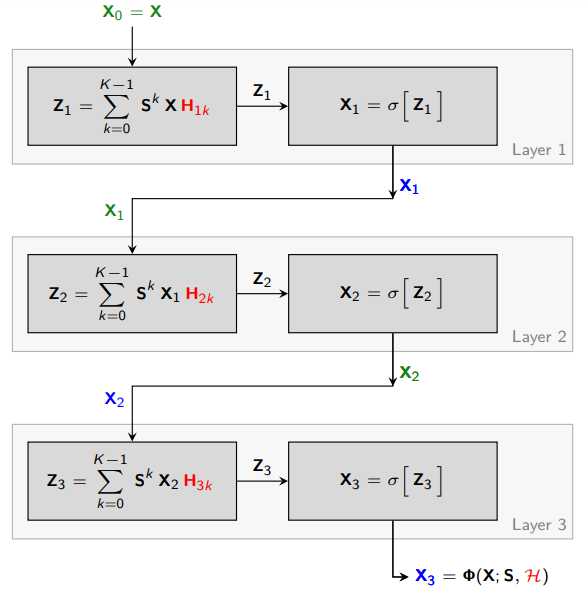

In [1]:
import numpy as np
import torch; torch.set_default_dtype(torch.float64)
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
import math

In this tutorial, we will use source localization as an example problem. This problems uses fake data that we generate so as to work in a controlled environment.<br>

Here, we consider stochastic block model (SBM) graphs. SBM graphs are unweighted and undirected graphs made up of $C$ communities. Nodes in the same community $C_i$ are connected with probability $p_{c_i c_i}$ (called intra-community probability) and nodes in different communities $c_i$ and $c_j$ are connected with probability $p_{c_i c_j}$ (called inter-community probability).

In [2]:
# The following function to generate the adjacency matrix of a SBM graph with balanced communities (i.e., communities of same size).

def sbm(n, c, p_intra, p_inter):
    
    # assign a community to each node
    community = np.repeat(list(range(c)), np.ceil(n / c))

    # make sure community vector has size n
    community = community[0:n]

    # make it a column vector
    community = np.expand_dims(community, 1)


    # generate a boolean matrix indicating whether two nodes 
    # are in the same community
    intra = community == community.T

    # generate a boolean matrix indicating whether two nodes 
    # are in different communities
    inter = np.logical_not(intra)

    # generate a matrix with random entries between 0 and 1
    random = np.random.random((n, n))

    # generate a triangular matrix with zeros below the main diagonal
    # because the SBM graph is symmetric, we only have to assign weights 
    # to the upper triangular part of the adjacency matrix,
    # and later copy them to the lower triangular part
    tri = np.tri(n, k=-1)


    # initialize adjacency matrix
    graph = np.zeros((n, n))

    # assign intra-community edges
    graph[np.logical_and.reduce([tri, intra, random < p_intra])] = 1

    # assign inter-community edges
    graph[np.logical_and.reduce([tri, inter, random < p_inter])] = 1

    # make the adjacency matrix symmetric
    graph += graph.T 


    return graph

In [3]:
# Generate an SBM graph.
N = 50 # number of nodes
S = sbm(n=N, c=5, p_intra=0.6, p_inter=0.2)
S

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 1., 1.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [4]:
# Normalizing the adjacency matrix with the eigenvalue

def normalize_gso(gso):
    
    # obtain eigenvalues
    eigenvalues, _ = np.linalg.eig(gso) 

    # normalize by eigenvalue with largest absolute value
    return gso / np.max(np.abs(eigenvalues))

S = normalize_gso(S)
S

array([[0.        , 0.06841956, 0.06841956, ..., 0.        , 0.        ,
        0.        ],
       [0.06841956, 0.        , 0.06841956, ..., 0.        , 0.06841956,
        0.06841956],
       [0.06841956, 0.06841956, 0.        , ..., 0.        , 0.06841956,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.06841956,
        0.        ],
       [0.        , 0.06841956, 0.06841956, ..., 0.06841956, 0.        ,
        0.06841956],
       [0.        , 0.06841956, 0.        , ..., 0.        , 0.06841956,
        0.        ]])

The source localization problem consists of identifying the sources of a graph diffusion process from an observation of the process at a given time $t=T$.

Consider a graph $\mathcal{G}=(\mathcal{V}, \mathcal{E}, \mathbf{S})$ with node set $\mathcal{V},|\mathcal{V}|=N$, edge set $\mathcal{E} \in \mathcal{V} \times \mathcal{V}$ and graph shift operator (GSO) $\mathbf{S} \in \mathbb{R}^{N \times N}$. Let $\mathcal{S}=\left\{s_1, \ldots, s_M\right\}$ denote a set of $M$ sources $s_i \in \mathcal{V}$. At time $t=0$, the graph signal $\mathbf{z}_0 \in \mathbb{R}^N$ is given by
$$
\left[\mathbf{z}_0\right]_i= \begin{cases}z \sim \mathcal{U}(a, b) & \text { if } i \in \mathcal{S} \\ 0 & \text { otherwise }\end{cases}
$$
where $\mathcal{U}(a, b)$ stands for the uniform distribution on the $[a, b]$ interval.
For $t>0, \mathbf{z}_t$ is the output of the diffusion of $\mathbf{z}_{t-1}$ on the graph, i.e.,
$$
\mathbf{z}_t=\mathbf{S} \mathbf{z}_{t-1}+\mathbf{w}_t
$$
where $\mathbf{w}_t \in \mathbb{R}^N$ is a Gaussian noise.
In order to generate the diffusion process as described by this equation with $a=0, b=10$ and horizon $T=4$, we implement the following Python function:

In [5]:
def generate_diffusion(gso, n_samples, n_sources):

    # get the number of nodes
    n = gso.shape[0]

    # initialize the tensor used to store the samples
    # shape is n_samples x n x time x 1 features
    z = np.zeros((n_samples, n, 5, 1))

    for i in range(n_samples):

        # pick n_sources at random from n nodes
        sources = np.random.choice(n, n_sources, replace=False)

        # define z_0 for each sample
        z[i, sources, 0, 0] = np.random.uniform(0,10, n_sources)

    # noise mean and variance
    mu = np.zeros(n)
    sigma = np.eye(n) * 1e-3

    for t in range(4):

        # generate noise
        noise = np.random.multivariate_normal(mu, sigma, n_samples)

        # generate z_t
        z[:, :, t + 1] = gso @ z[:, :, t] + np.expand_dims(noise, -1)
        
    # transpose dimensions so shape is n_samples x time x n x 1 feature
    z = z.transpose((0, 2, 1, 3))
    
    # squeeze feature dimension, as there is only 1 feature
    return z.squeeze()

In [6]:
z = generate_diffusion(S, 2100, 10)
z.shape

(2100, 5, 50)

In [7]:
def data_from_diffusion(z):
    
    # permute the samples in z
    z = np.random.permutation(z)
    
    # define the output tensor
    y = np.expand_dims(z[:, 0, :], 1)
    
    # initialize the input tensor
    x = np.zeros(y.shape)
    
    # define the input tensor as x = z_4
    for i, sample in enumerate(z):
        x[i] = sample[4]
   
    # squeeze time dimension     
    return x.squeeze(), y.squeeze()

In [8]:
x, y = data_from_diffusion(z)
x.shape, y.shape

((2100, 50), (2100, 50))

Now, we will split the data and separate input and output data.

In [9]:
def split_data(x, y, splits=(2000, 100)):

    # define the initial index of each set (training/test)
    splits = np.cumsum([0] + list(splits))
    splits = (splits * x.shape[0] / splits[-1]).astype(int)

    # return training and test data as tuples
    return ((x[splits[i]:splits[i + 1]], y[splits[i]:splits[i + 1]]) for i in range(len(splits) - 1))

In [10]:
trainData, testData = split_data(x, y, (2000,100))
xTrain = trainData[0]
yTrain = trainData[1]
xTest = testData[0]
yTest = testData[1]

In [11]:
xTrain = torch.tensor(xTrain).float()
xTrain = xTrain.reshape([-1,1,N])
yTrain = torch.tensor(yTrain).float()
yTrain = yTrain.reshape([-1,1,N])

xTest = torch.tensor(xTest).float()
xTest = xTest.reshape([-1,1,N])
yTest = torch.tensor(yTest).float()
yTest = yTest.reshape([-1,1,N])

Below, we implement the funtion which applies and graph filter to a graph shift operator **S** and a graph signal **x**.

In [12]:
def FilterFunction(h, S, x):
    
    # Number of output features
    F = h.shape[0]
    
    # Number of filter taps
    K = h.shape[1]
    
    # Number of input features
    G = h.shape[2]
    
    # Number of nodes
    N = S.shape[1]
    
    # Batch size
    B = x.shape[0]

    # Create concatenation dimension and initialize concatenation tensor z
    x = x.reshape([B, 1, G, N])
    S = S.reshape([1, N, N])
    z = x
    
    # Loop over the number of filter taps
    for k in range(1, K):
        
        # S*x
        x = torch.matmul(x, S)
        
        # Reshape
        xS = x.reshape([B, 1, G, N])
        
        # Concatenate
        z = torch.cat((z, xS), dim=1)
    
    # Multiply by h
    y = torch.matmul(z.permute(0, 3, 1, 2).reshape([B, N, K*G]), 
                     h.reshape([F, K*G]).permute(1, 0)).permute(0, 2, 1)
    return y
    

Given graph shift operator $\textbf{S}$ and coefficients $h_k$ , a graph filter is a polynomial (series) on $\textbf{S}$.

$$\mathbf{H(S)} = \sum^{\infty}_{k=0} h_k \mathbf{S}^k$$

The result of applying the filter H(S) to the signal x is the signal.

$$\mathbf{y} = \mathbf{H(S)x} = \sum^{\infty}_{k=0} h_k \mathbf{S}^k \mathbf{x}$$

In [13]:
class GraphFilter(nn.Module):
    def __init__(self, gso, k, f_in, f_out):
        super().__init__()
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.k = k
        self.f_in = f_in
        self.f_out = f_out
        self.weight = nn.Parameter(torch.randn(self.f_out, self.k, self.f_in))
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.f_in * self.k)
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        return FilterFunction(self.weight, self.gso, x)

In [14]:
class GNN(nn.Module):
    def __init__(self, gso, l, k, f, sigma):
        super().__init__()
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.l = l
        self.k = k
        self.f = f
        self.sigma = sigma
        
        gml = []
        for layer in range(l):
            gml.append(GraphFilter(gso,k[layer],f[layer],f[layer+1]))
            gml.append(sigma)
        
        self.gml = nn.Sequential(*gml)
        
    def forward(self, x):
        return self.gml(x)

In [15]:
S = torch.from_numpy(S).float()

Setting up the training loop.

In [33]:
nTrain = 2000
nTest = 100

loss = nn.MSELoss()

validationInterval = 5

nEpochs = 50
batchSize = 200
learningRate = 0.05

nValid = int(np.floor(0.01*nTrain))
xValid = xTrain[0:nValid,:,:]
yValid = yTrain[0:nValid,:,:]
xTrain = xTrain[nValid:,:,:]
yTrain = yTrain[nValid:,:,:]
nTrain = xTrain.shape[0]

if nTrain < batchSize:
    nBatches = 1
    batchSize = [nTrain]
elif nTrain % batchSize != 0:
    nBatches = np.ceil(nTrain/batchSize).astype(np.int64)
    batchSize = [batchSize] * nBatches
    while sum(batchSize) != nTrain:
        batchSize[-1] -= 1
else:
    nBatches = np.int(nTrain/batchSize)
    batchSize = [batchSize] * nBatches
batchIndex = np.cumsum(batchSize).tolist()
batchIndex = [0] + batchIndex

In [34]:
def train_func(model):
    epoch = 0 # epoch counter

    # Store the training...
    lossTrain = dict()
    lossValid = dict()
    # ...and test variables
    lossTestBest = dict()
    lossTestLast = dict()

    bestModel = dict()

    lossTrain = []
    lossValid = []

    # Declaring the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learningRate)
        
    while epoch < nEpochs:
        randomPermutation = np.random.permutation(nTrain)
        idxEpoch = [int(i) for i in randomPermutation]
        print("")
        print("Epoch %d" % (epoch+1))

        batch = 0 
        
        while batch < nBatches:
            # Determine batch indices
            thisBatchIndices = idxEpoch[batchIndex[batch]
                                        : batchIndex[batch+1]]
            
            # Get the samples in this batch
            xTrainBatch = xTrain[thisBatchIndices,:]
            yTrainBatch = yTrain[thisBatchIndices,:]

            if (epoch * nBatches + batch) % validationInterval == 0:
                print("")
                print("    (E: %2d, B: %3d)" % (epoch+1, batch+1),end = ' ')
                print("")
            
          
            # Reset gradients
            model.zero_grad()

            # Obtain the output of the architectures
            yHatTrainBatch = model(xTrainBatch)

            # Compute loss
            lossValueTrain = loss(yHatTrainBatch, yTrainBatch)

            # Compute gradients
            lossValueTrain.backward()

            # Optimize
            optimizer.step()
            
            lossTrain += [lossValueTrain.item()]
            
            # Print:
            if (epoch * nBatches + batch) % validationInterval == 0:
                with torch.no_grad():
                    # Obtain the output of the GNN
                    yHatValid = model(xValid)
        
                # Compute loss
                lossValueValid = loss(yHatValid, yValid)
                
                lossValid += [lossValueValid.item()]

                print("\t Model Loss: %6.4f [T]" % (
                        lossValueTrain) + " %6.4f [V]" % (
                        lossValueValid))
                
                # Saving the best model so far
                if len(lossValid) > 1:
                    if lossValueValid <= min(lossValid):
                        bestModel =  copy.deepcopy(model)
                else:
                    bestModel =  copy.deepcopy(model)
                        
            batch+=1
            
        epoch+=1

    return model, bestModel, lossTrain, lossValid
  

### 2-Layered GNN

Here, we will use a 2-layer network and see how well it can learn.

In [35]:
model_1 = GNN(gso=S, l=2, k=[8,1], f=[1,32,1], sigma=nn.ReLU()).float()

<ipython-input-14-adc1e268fbf6>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.gso = torch.tensor(gso)


In [36]:
model_trained, bestModel, lossTrain, lossValid = train_func(model_1)


Epoch 1

    (E:  1, B:   1) 
	 Model Loss: 6.5267 [T] 5.8303 [V]

    (E:  1, B:   6) 
	 Model Loss: 5.8082 [T] 5.8865 [V]

Epoch 2

    (E:  2, B:   1) 
	 Model Loss: 5.6853 [T] 5.7980 [V]

    (E:  2, B:   6) 
	 Model Loss: 5.5906 [T] 5.7700 [V]

Epoch 3

    (E:  3, B:   1) 
	 Model Loss: 5.6769 [T] 5.7583 [V]

    (E:  3, B:   6) 
	 Model Loss: 5.5077 [T] 5.7592 [V]

Epoch 4

    (E:  4, B:   1) 
	 Model Loss: 5.6471 [T] 5.7614 [V]

    (E:  4, B:   6) 
	 Model Loss: 5.6902 [T] 5.7578 [V]

Epoch 5

    (E:  5, B:   1) 
	 Model Loss: 5.6645 [T] 5.7548 [V]

    (E:  5, B:   6) 
	 Model Loss: 5.6005 [T] 5.7509 [V]

Epoch 6

    (E:  6, B:   1) 
	 Model Loss: 5.6495 [T] 5.7479 [V]

    (E:  6, B:   6) 
	 Model Loss: 5.4824 [T] 5.7443 [V]

Epoch 7

    (E:  7, B:   1) 
	 Model Loss: 5.7224 [T] 5.7407 [V]

    (E:  7, B:   6) 
	 Model Loss: 5.5792 [T] 5.7364 [V]

Epoch 8

    (E:  8, B:   1) 
	 Model Loss: 5.5014 [T] 5.7317 [V]

    (E:  8, B:   6) 
	 Model Loss: 5.6289 [T] 5.7263 [V]


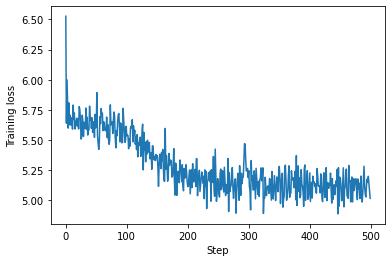

In [37]:
# Training Loss Plot
plt.plot(lossTrain)
plt.ylabel('Training loss')
plt.xlabel('Step')
plt.show()

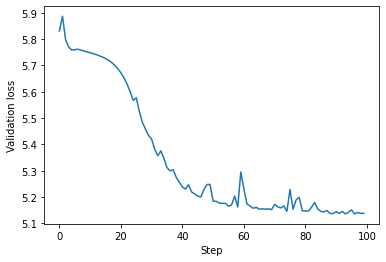

In [38]:
# Validation Loss Plot
plt.plot(lossValid)
plt.ylabel('Validation loss')
plt.xlabel('Step')
plt.show()

In [39]:
# Evalutation

print("Final evaluation results")

with torch.no_grad():
    yHatTest = model_trained(xTest)
lossTestLast = loss(yHatTest, yTest)
lossTestLast = lossTestLast.item()
with torch.no_grad():
    yHatTest = bestModel(xTest)
lossTestBest = loss(yHatTest, yTest)
lossTestBest = lossTestBest.item()

print(" Mean Squared Error: %6.4f [Best]" % (
                    lossTestBest) + " %6.4f [Last]" % (
                    lossTestLast))

Final evaluation results
 Mean Squared Error: 5.2745 [Best] 5.2810 [Last]


### 3-Layered GNN

In [40]:
model_2 = GNN(gso=S, l=3, k=[5,5,1], f=[1,16,4,1], sigma=nn.ReLU()).float()

<ipython-input-14-adc1e268fbf6>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.gso = torch.tensor(gso)


In [41]:
model_trained, bestModel, lossTrain, lossValid = train_func(model_2)


Epoch 1

    (E:  1, B:   1) 
	 Model Loss: 6.3699 [T] 5.7694 [V]

    (E:  1, B:   6) 
	 Model Loss: 6.2953 [T] 6.3816 [V]

Epoch 2

    (E:  2, B:   1) 
	 Model Loss: 6.0989 [T] 6.2650 [V]

    (E:  2, B:   6) 
	 Model Loss: 5.3954 [T] 5.7895 [V]

Epoch 3

    (E:  3, B:   1) 
	 Model Loss: 5.6511 [T] 5.7710 [V]

    (E:  3, B:   6) 
	 Model Loss: 5.7823 [T] 5.8763 [V]

Epoch 4

    (E:  4, B:   1) 
	 Model Loss: 5.6240 [T] 5.8051 [V]

    (E:  4, B:   6) 
	 Model Loss: 5.6238 [T] 5.7719 [V]

Epoch 5

    (E:  5, B:   1) 
	 Model Loss: 5.6294 [T] 5.7769 [V]

    (E:  5, B:   6) 
	 Model Loss: 5.7102 [T] 5.7804 [V]

Epoch 6

    (E:  6, B:   1) 
	 Model Loss: 5.5684 [T] 5.7777 [V]

    (E:  6, B:   6) 
	 Model Loss: 5.6811 [T] 5.7709 [V]

Epoch 7

    (E:  7, B:   1) 
	 Model Loss: 5.6788 [T] 5.7684 [V]

    (E:  7, B:   6) 
	 Model Loss: 5.6227 [T] 5.7675 [V]

Epoch 8

    (E:  8, B:   1) 
	 Model Loss: 5.7226 [T] 5.7675 [V]

    (E:  8, B:   6) 
	 Model Loss: 5.6566 [T] 5.7675 [V]


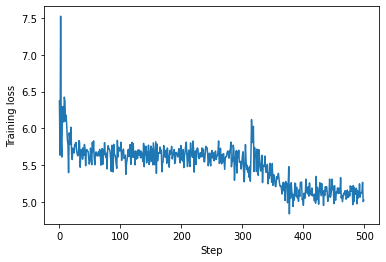

In [42]:
# Training Loss Plot
plt.plot(lossTrain)
plt.ylabel('Training loss')
plt.xlabel('Step')
plt.show()

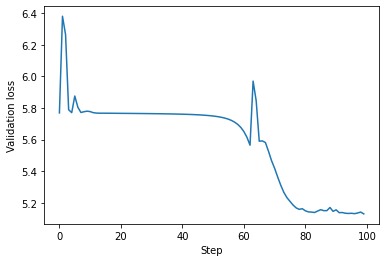

In [43]:
# Validation Loss Plot
plt.plot(lossValid)
plt.ylabel('Validation loss')
plt.xlabel('Step')
plt.show()

In [44]:
# Evalutation

print("Final evaluation results")

with torch.no_grad():
    yHatTest = model_2(xTest)
lossTestLast = loss(yHatTest, yTest)
lossTestLast = lossTestLast.item()
with torch.no_grad():
    yHatTest = bestModel(xTest)
lossTestBest = loss(yHatTest, yTest)
lossTestBest = lossTestBest.item()

print(" Mean Squared Error: %6.4f [Best]" % (
                    lossTestBest) + " %6.4f [Last]" % (
                    lossTestLast))

Final evaluation results
 Mean Squared Error: 5.2833 [Best] 5.2870 [Last]
